In [21]:
import tensorflow as tf
import os
import pathlib
print("tensorflow version", tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

tensorflow version 2.15.0


In [22]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [23]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['close' 'down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [24]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8042 files belonging to 9 classes.
Using 6434 files for training.
Using 1608 files for validation.

label names: ['close' 'down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [25]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [26]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [27]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [28]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [29]:
label_names[[1,1,3,0]]

array(['down', 'down', 'left', 'close'], dtype='<U5')

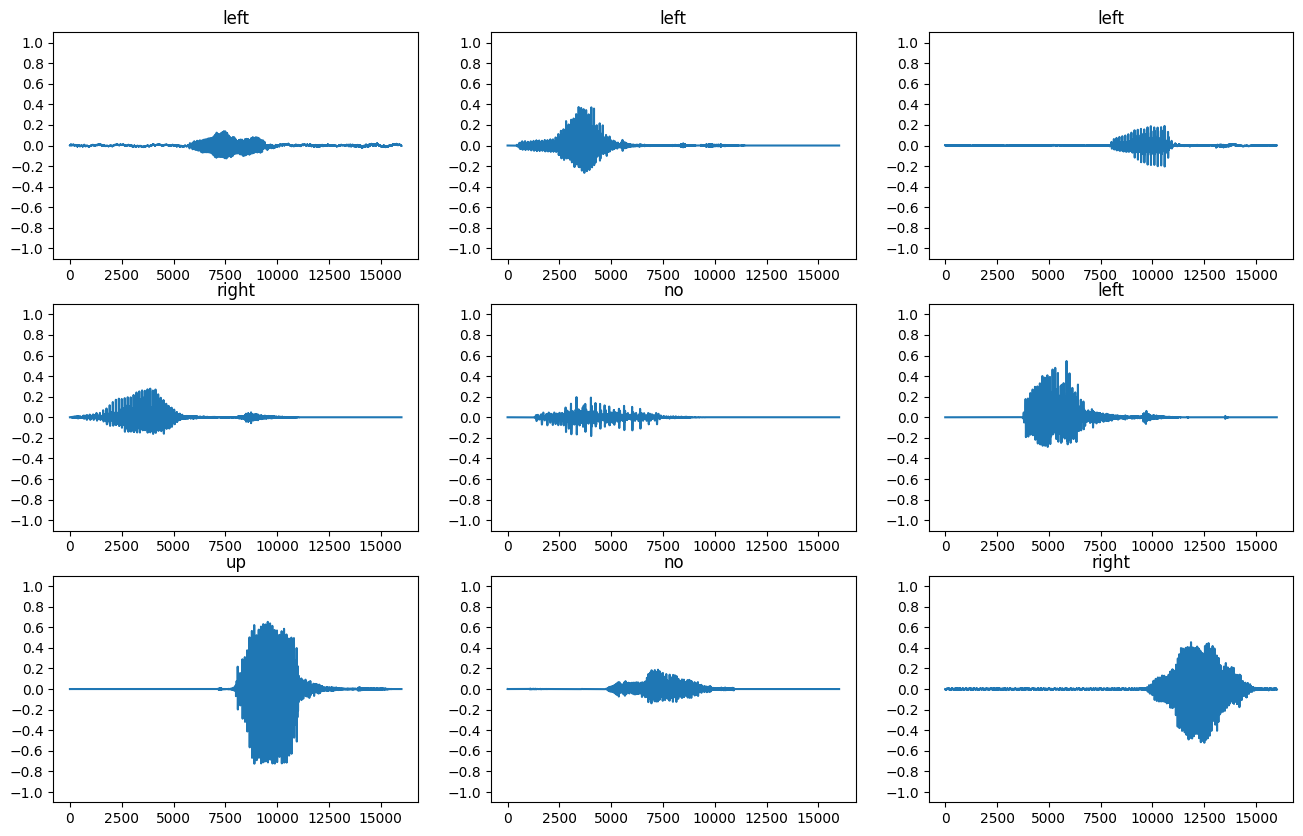

In [30]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [31]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [32]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [33]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

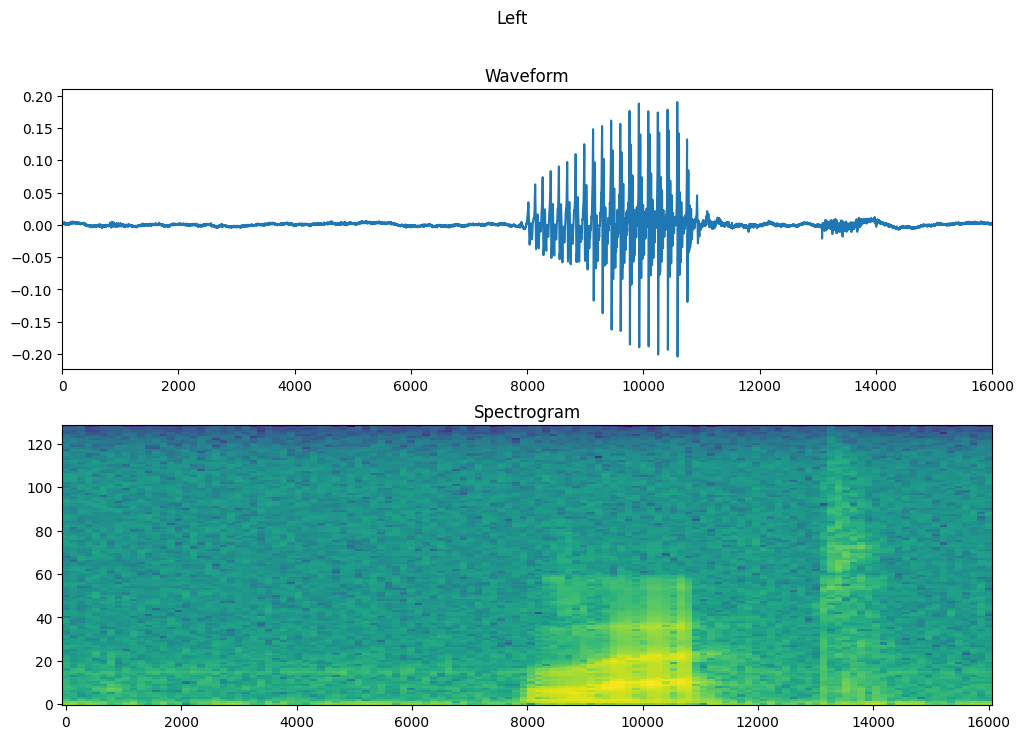

In [34]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [35]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [36]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [37]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

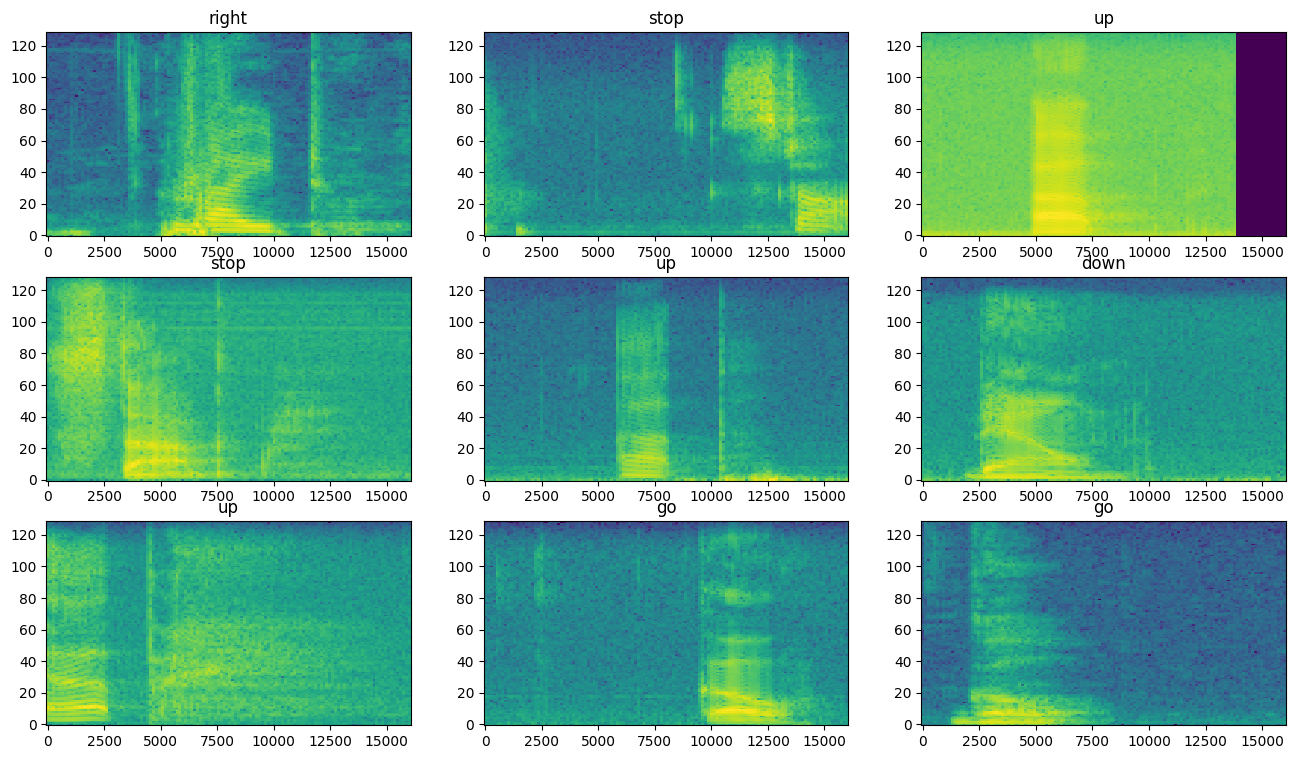

In [38]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [39]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [44]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


InvalidArgumentError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\aroze\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 604, in run_forever

  File "C:\Users\aroze\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Users\aroze\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\aroze\AppData\Local\Temp\ipykernel_7060\3992220132.py", line 9, in <module>

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\keras\src\layers\preprocessing\normalization.py", line 287, in adapt

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\keras\src\engine\base_preprocessing_layer.py", line 258, in adapt

  File "c:\Users\aroze\Documents\MQP\VoiceRecognitionV1\venv\Lib\site-packages\keras\src\engine\base_preprocessing_layer.py", line 121, in adapt_step

Cannot batch tensors with different shapes in component 0. First element had shape [16000,1] and element 41 had shape [16000,2].
	 [[{{node IteratorGetNext}}]] [Op:__inference_adapt_step_3173]

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

NameError: name 'model' is not defined

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10




100/100 [==============================] - 19s 162ms/step - loss: 1.7158 - accuracy: 0.3744 - val_loss: 1.2807 - val_accuracy: 0.6159
Epoch 2/10
100/100 [==============================] - 9s 88ms/step - loss: 1.1825 - accuracy: 0.5806 - val_loss: 0.9301 - val_accuracy: 0.7161
Epoch 3/10
100/100 [==============================] - 9s 89ms/step - loss: 0.8952 - accuracy: 0.6814 - val_loss: 0.7549 - val_accuracy: 0.7617
Epoch 4/10
100/100 [==============================] - 8s 84ms/step - loss: 0.7279 - accuracy: 0.7448 - val_loss: 0.6599 - val_accuracy: 0.7891
Epoch 5/10
100/100 [==============================] - 9s 87ms/step - loss: 0.6249 - accuracy: 0.7819 - val_loss: 0.5776 - val_accuracy: 0.8398
Epoch 6/10
100/100 [==============================] - 9s 86ms/step - loss: 0.5517 - accuracy: 0.8077 - val_loss: 0.5770 - val_accuracy: 0.8177
Epoch 7/10
100/100 [==============================] - 9s 88ms/step - loss: 0.4776 - accuracy: 0.8253 - val_loss: 0.5336 - val_accuracy: 0.8294
Epoch 

In [ ]:
model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets
